In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import os
import pandas as pd
import seaborn as sns

from sklearn.datasets import fetch_kddcup99
from sklearn.preprocessing import StandardScaler


from pyspark import SparkContext, SparkConf
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import SparkSession
from pyspark.sql.functions import pandas_udf, col

from utils import compute_centroidDistances, get_clusterId, get_minDistance

In [2]:
os.environ["PYSPARK_PYTHON"] = "./environment/bin/python"

In [3]:
env_path = "environment.tar.gz"
env_path = os.path.abspath(env_path)

conf = SparkConf().set("spark.archives", f"{env_path}#environment") \
    .set("spark.executor.memory", "4096m")

In [4]:
# build a SparkSession 
#   connect to the master node on the port where the master node is listening (7077)
#   declare the app name 
#   configure the executor memory to 512 MB
#   either *connect* or *create* a new Spark Context
spark = SparkSession.builder \
    .master("spark://master:7077")\
    .appName("kMeansParallel")\
    .config(conf = conf)\
    .getOrCreate()

sc = spark.sparkContext
sc.addPyFile("utils.py") # we need to export other files to the cluster

25/09/08 08:59:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### Naming conventions

The single datum is named as `datumName`, while the RDD that is a collection of one or more data is called `datumName_rdd`.

Example: `compute_clusterDistances` returns `clusterDistances` (i.e. a numpy array of distances between a point `x` and the `centroids`). 
The RDD that collects all the `clusterDistances` will be called `clusterDistances_rdd`, and here is a sample implementation of that:
```python
def compute_centroidDistances(x, centroids):
    return np.sum((centroids - x)**2, axis = 1)

# `data_rdd` is an RDD
# `centroids` is a numpy array
clusterDistances_rdd = data_rdd \
    .map(lambda x: compute_clusterDistances(x, centroids))
```

### Load and preprocess the dataset

In [5]:
#Real dataset

# Change percent10 to 'False' to fetch the full dataset (4M rows)
# for local works is better to leave it as 'True'
kdd = fetch_kddcup99(shuffle=True,percent10=True) 
kdd_data = kdd.data

# Remove string features and standardize them
data = np.delete(kdd_data,np.arange(1,4,1),axis = 1) 
scaler = StandardScaler()
data = scaler.fit_transform(data)


#parallelize
data_rdd = sc.parallelize([row for row in data])
data_rdd = data_rdd.persist()

In [17]:
def kMeansPlusPlus_init(
    data: npt.NDArray,
    k: int,
    weights: npt.NDArray = np.array([])
) -> npt.NDArray:
    """
    Standard kMeans++ initialization method:
    given `data` (eventually weighted), returns `k` cluster centroids
    """
    if weights.shape[0] == 0:
        weights = np.ones(shape=(data.shape[0],1))
    
    centroids = data[np.random.randint(0, data.shape[0]),:].reshape(1, -1) # reshaping for easier stacking
    
    while (centroids.shape[0] < k):
        # since the original functions are made for map
        # we need to loop over the data
        minDistance_array = np.array(
            [get_minDistance(compute_centroidDistances(datum, centroids)) for datum in data]
        ) * weights # multiplyling by the weight simulates multiple copies of the same datum
        total_minDistance = np.sum(minDistance_array)
        # sampling probability proportional to minDistance
        new_centroid_idx = np.random.choice(minDistance_array.shape[0], size = 1, p = minDistance_array / total_minDistance)
        new_centroid = data[new_centroid_idx,:].reshape(1, -1)

        # edge case in which the same centroid is selected twice:
        # redo the iteration without saving the centroid
        if any(np.array_equal(new_centroid, row) for row in centroids): continue
        centroids = np.concatenate((centroids, new_centroid), axis = 0)

    return centroids

In [18]:
def kMeansNaive(
    data: npt.NDArray,
    centroids: npt.NDArray,
    epochs: int = 5
) -> npt.NDArray:
    """
    Standard kMeans algorithm:
    given `data`, updates the (k) `centroids` for `epochs` times,
    improving the clustering each time
    """
    k = centroids.shape[0]
    for _ in range(epochs):
        assignments = np.array(
            [get_clusterId(compute_centroidDistances(x, centroids)) for x in data]
        )
        centroids = np.array(
            [np.mean(data[assignments==i,:], axis = 0) for i in range(k)]
        )
    return centroids

In [19]:
def kMeansParallel_init(
    data_rdd: RDD,
    k: int,
    l: float
) -> npt.NDArray:
    """
    kMeans|| initialization method:
    returns `k` good `centroids`.
    `l` controls the probability of each point
    in `data_rdd` of being sampled as a pre-processed centroid.
    """

    centroids = np.array(
        data_rdd.takeSample(num=1, withReplacement=False)
    )
    
    minDistance_rdd = data_rdd \
        .map(lambda x: (x, get_minDistance(compute_centroidDistances(x, centroids)))) \
        .persist()

    cost = minDistance_rdd \
        .map(lambda x: x[1]) \
        .sum()

    iterations = int(np.ceil(np.log(cost))) if (cost > 1) else 1
    for _ in range(iterations):
        new_centroids = np.array(
            minDistance_rdd \
                .filter(lambda x: np.random.rand() < np.min((l * x[1] / cost, 1))) \
                .map(lambda x: x[0]) \
                .collect()
        )
        # edge case in which no new centroid is sampled:
        # this avoids the following `np.concatenate` to fail
        if len(new_centroids.shape) < 2:
            continue

        minDistance_rdd.unpersist()
        centroids = np.unique(
            np.concatenate((centroids, new_centroids), axis = 0), 
            axis = 0
        )

        minDistance_rdd = data_rdd \
            .map(lambda x: (x, get_minDistance(compute_centroidDistances(x, centroids)))) \
            .persist()
        cost = minDistance_rdd \
            .map(lambda x: x[1]) \
            .sum()
    
    minDistance_rdd.unpersist()
    clusterCounts = data_rdd \
        .map(lambda x: (get_clusterId(compute_centroidDistances(x, centroids)), 1)) \
        .countByKey()
    
    clusterCounts = np.array([w[1] for w in clusterCounts.items()])
    centroids = kMeansNaive(
        centroids, 
        kMeansPlusPlus_init(centroids, k, clusterCounts)
    )
    
    return centroids

In [20]:
k = 10
l = k * 10
centroids = kMeansParallel_init(data_rdd, k, l)

25/09/08 08:25:31 WARN TaskSetManager: Stage 2 contains a task of very large size (10124 KiB). The maximum recommended task size is 1000 KiB.
25/09/08 08:25:33 WARN TaskSetManager: Stage 3 contains a task of very large size (10124 KiB). The maximum recommended task size is 1000 KiB.
25/09/08 08:25:34 WARN TaskSetManager: Stage 4 contains a task of very large size (10124 KiB). The maximum recommended task size is 1000 KiB.
25/09/08 08:25:35 WARN TaskSetManager: Stage 5 contains a task of very large size (10124 KiB). The maximum recommended task size is 1000 KiB.
25/09/08 08:25:37 WARN TaskSetManager: Stage 6 contains a task of very large size (10124 KiB). The maximum recommended task size is 1000 KiB.
25/09/08 08:25:38 WARN TaskSetManager: Stage 7 contains a task of very large size (10124 KiB). The maximum recommended task size is 1000 KiB.
25/09/08 08:25:40 WARN TaskSetManager: Stage 8 contains a task of very large size (10124 KiB). The maximum recommended task size is 1000 KiB.
25/09/

In [21]:
centroids

array([[ 4.06340713e-01, -1.06522698e-03,  1.66862140e-01,
        -6.67341765e-03, -4.77201854e-02, -2.57146810e-03,
         5.39575499e-01, -9.78218463e-03,  2.39697959e+00,
         5.38305955e-01,  6.17073578e+00,  1.11541626e+01,
         6.64015267e-01,  3.82180451e+00,  3.93547709e+00,
         3.15546518e+01,  0.00000000e+00,  0.00000000e+00,
         5.46949897e-01, -1.54813832e+00, -1.17843900e+00,
        -4.64089752e-01, -4.63520471e-01, -2.47960476e-01,
        -8.10086720e-02,  4.52985313e-01,  3.63567044e-01,
         1.81612889e+00, -1.26000582e+00, -5.30688332e-01,
        -2.20358110e-01,  5.56781581e-01, -1.08169734e+00,
         7.87153047e-02, -3.78738908e-01, -3.80450589e-01,
        -2.08672371e-01, -2.32461128e-01],
       [ 9.35430121e+00,  1.91496228e-02,  6.08384609e+00,
        -6.67341765e-03, -4.77201854e-02,  1.49726235e+00,
         4.11397516e+00, -9.78218463e-03,  9.43378714e-01,
         7.93407700e-02,  2.73101093e+00, -4.67567073e-03,
         1.21

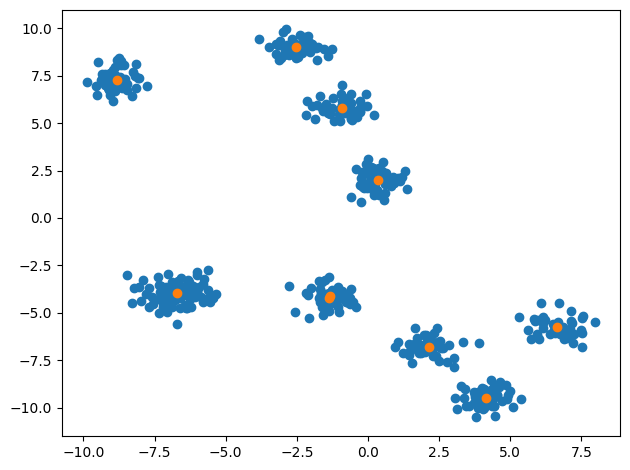

In [ ]:
"""
data = np.array(data)
centroids = np.array(centroids)
fig, ax = plt.subplots()
ax.scatter(data[:,0], data[:,1])
ax.scatter(centroids[:,0], centroids[:,1])
fig.tight_layout()
"""

In [22]:
def miniBatchKMeans(
    data_rdd: RDD,
    centroids: npt.NDArray,
    iterations: int = 10,
    batch_fraction: float = 0.1
) -> npt.NDArray:
    k = centroids.shape[0]
    clusterCounters = np.zeros((k,)) # 1 / learning_rate
    for iter in range(iterations):
        miniBatch_rdd = data_rdd \
            .sample(withReplacement=False, fraction=batch_fraction)
        miniBatch_rdd = miniBatch_rdd \
            .map(lambda x: (get_clusterId(compute_centroidDistances(x, centroids)), 1, x)) \
            .persist()
        
        # counting how many assigments per cluster
        clusterCounts_dict = miniBatch_rdd \
            .map(lambda x: (x[0], x[1])) \
            .countByKey()
        clusterCounts = np.array(
            [clusterCounts_dict[i] if i in clusterCounts_dict.keys() else 0 for i in range(k)]
        )
        clusterCounters += clusterCounts
        
        # edge case in which a cluster has no assignments:
        # if also its counter is zero the whole iteration is repeated
        if any(np.isclose(v, 0) for v in clusterCounters): 
            iter -= 1
            miniBatch_rdd.unpersist()
            continue
        # otherwise its count will be set to 1 to avoid division by 0 in the update step
        clusterCounts = np.where(clusterCounts >= 1, clusterCounts, 1)

        # summing all points assigned to the same cluster
        # (in the update step this will be divided by the counts 
        # in order to get the mean for every cluster).
        # A dict is used for convenience and consistency with clusterCounts
        clusterSums_dict = dict(miniBatch_rdd \
            .map(lambda x: (x[0], x[2])) \
            .reduceByKey(lambda x, y: x + y) \
            .collect()
        )
        # edge case in which a cluster has no assignments:
        # the centroid is returned instead of 0 
        # (which would have been the sum of its assigned points) 
        # in order to not update its position 
        # (note how the terms cancel out in the update step)
        clusterSums = np.array(
            [clusterSums_dict[i] if i in clusterSums_dict.keys() else centroids[i,:] for i in range(k)]
        )

        # update step: c <- (1 - eta) * c + eta * x_mean
        # (note x_mean = x_sums / c_count)
        centroids = (1 - 1 / clusterCounters).reshape(-1, 1) * centroids + \
                    (1 / (clusterCounters * clusterCounts)).reshape(-1, 1) * clusterSums
        
        miniBatch_rdd.unpersist()
        
    return centroids

In [23]:
final_centroids = miniBatchKMeans(data_rdd, centroids, 10, 0.1)

25/09/08 08:28:23 WARN TaskSetManager: Stage 40 contains a task of very large size (10124 KiB). The maximum recommended task size is 1000 KiB.
25/09/08 08:28:24 WARN TaskSetManager: Stage 41 contains a task of very large size (10124 KiB). The maximum recommended task size is 1000 KiB.
25/09/08 08:28:24 WARN TaskSetManager: Stage 42 contains a task of very large size (10124 KiB). The maximum recommended task size is 1000 KiB.
25/09/08 08:28:25 WARN TaskSetManager: Stage 43 contains a task of very large size (10124 KiB). The maximum recommended task size is 1000 KiB.
25/09/08 08:28:26 WARN TaskSetManager: Stage 44 contains a task of very large size (10124 KiB). The maximum recommended task size is 1000 KiB.
25/09/08 08:28:27 WARN TaskSetManager: Stage 45 contains a task of very large size (10124 KiB). The maximum recommended task size is 1000 KiB.
25/09/08 08:28:28 WARN TaskSetManager: Stage 46 contains a task of very large size (10124 KiB). The maximum recommended task size is 1000 KiB.

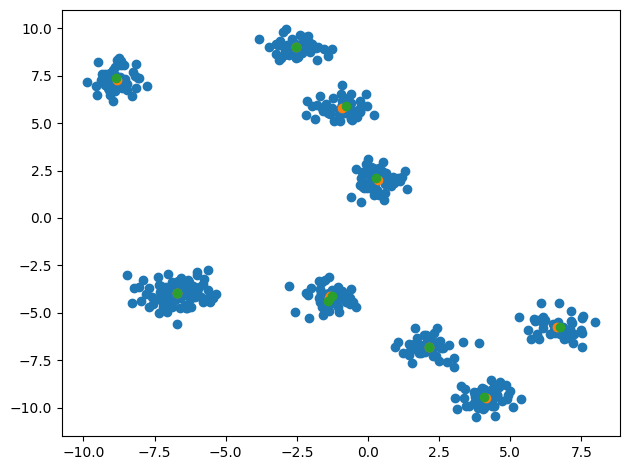

In [ ]:
"""
data = np.array(data)
centroids = np.array(centroids)
fig, ax = plt.subplots()
ax.scatter(data[:,0], data[:,1])
ax.scatter(centroids[:,0], centroids[:,1])
ax.scatter(final_centroids[:,0], final_centroids[:,1])
fig.tight_layout()
"""

In [24]:
sc.stop()
spark.stop()